In this notebook, we are going to experiment with different quanitization strategies supported by the [TensorFlow Model Optimization Toolkit](https://www.tensorflow.org/model_optimization) and TensorFlow Lite. These will include:
- Post-training quantization
- Quantization-aware training

We will start by training an image classification model using the traditional transfer learning process with a pre-trained MobileNetV2 network. We will then proceed towards the different quantization schemes. 

## Initial setup

In [0]:
# Install a stable version of TensorFlow (in order for the TF Lite stuff to work)
# Reference:
# - https://github.com/tensorflow/tensorflow/issues/38062
# - https://github.com/tensorflow/tensorflow/issues/38232
!pip install tensorflow-gpu==2.1.0

In [0]:
# Install optimization toolkit and wandb
!pip install tensorflow-model-optimization
!pip install wandb

In [0]:
# wandb authorization
import wandb
wandb.login()

In [0]:
# TensorFlow import
import tensorflow as tf
print(tf.__version__)

2.1.0


In [0]:
# Which GPU?
!nvidia-smi

Tue Apr 28 07:40:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Other imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from wandb.keras import WandbCallback
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random
import shutil
import time
import cv2
import os

## Dataset preparation

In [0]:
# Gather Flowers-17 dataset
data_root = tf.keras.utils.get_file(
  "/content/flower_photos", "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
   untar=True)

228818944/228813984 [==============================] - 2s 0us/step


In [0]:
# Untar the dataset
!tar -xvf flower_photos.tar.gz
!rm -rf flower_photos.tar.gz

In [0]:
# All the paths of the flowers and shuffle them
ALL_IMG_PATHS = list(paths.list_images("flower_photos"))
random.shuffle(ALL_IMG_PATHS)

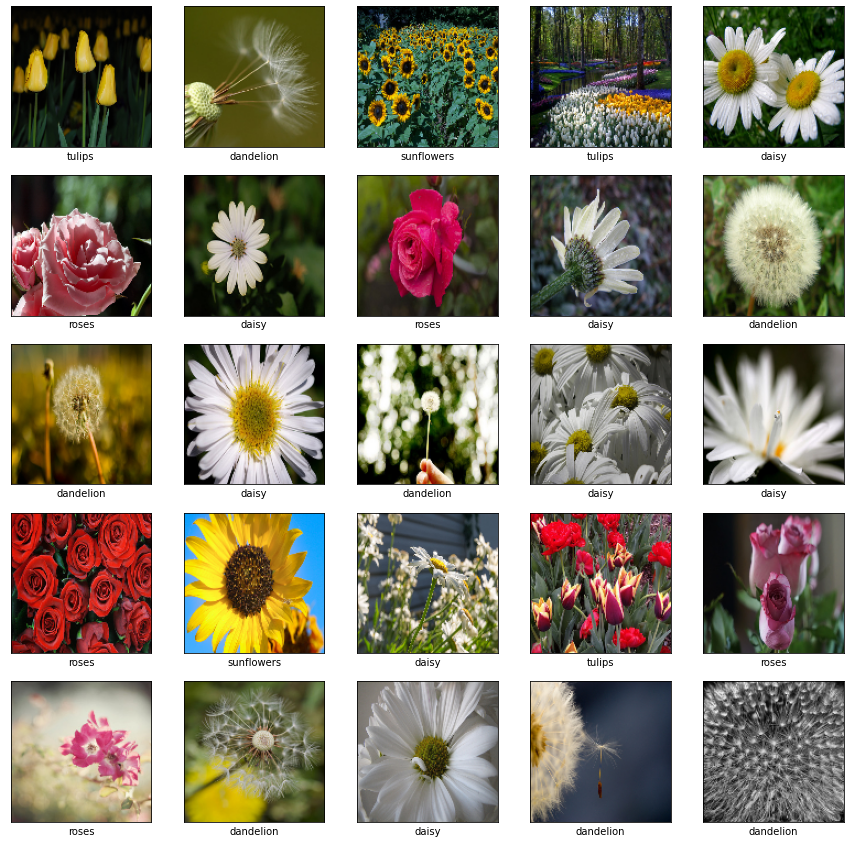

In [0]:
# Visualize images
plt.figure(figsize=(15,15))
for i in range(25):
    image_path = np.random.choice(ALL_IMG_PATHS)
    image = plt.imread(image_path)
    image = cv2.resize(image, (128, 128))
    # you might want to verify the labels before 
    # you put this to use
    label = image_path.split("/")[1]
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(image)
    plt.xlabel(label)
plt.show()

In [0]:
# split image paths into test and train splits
testImgs = int(len(ALL_IMG_PATHS) * 0.15)
trainImgs = len(ALL_IMG_PATHS) - testImgs
trainImgPaths = ALL_IMG_PATHS[:trainImgs]
testImgPaths = ALL_IMG_PATHS[trainImgs:]

In [0]:
# Specify the directory paths
train_dir = "train"
val_dir = "val"

In [0]:
def move_images(imgPaths, outputDir):
	# iterate through the image paths
	for imagePath in imgPaths:
		# extract the label from the current image path
		label = imagePath.split("/")[1]

		# check if a directory for the label exists, if not, create it
		imageDir = os.path.join(outputDir, label)
		if not os.path.exists(imageDir):
			os.makedirs(imageDir)

		# copy the current image to the respective folder
		shutil.copy2(imagePath, imageDir)

In [0]:
# Prepare the train and test set
move_images(trainImgPaths, train_dir)
move_images(testImgPaths, val_dir)

In [0]:
# Setup data generators
train_aug = ImageDataGenerator(rescale=1/255.)
val_aug = ImageDataGenerator(rescale=1/255.)

train_gen = train_aug.flow_from_directory("train",
    class_mode="categorical",
    target_size=(224, 224),
	color_mode="rgb",
	shuffle=True,
	batch_size=32
)
val_gen = train_aug.flow_from_directory("val",
    class_mode="categorical",
    target_size=(224, 224),
	color_mode="rgb",
	shuffle=False,
	batch_size=32
)

Found 3120 images belonging to 5 classes.
Found 550 images belonging to 5 classes.


## Initial model training setup

In [0]:
# Load the MobileNetV2 model but exclude the classification layers
EXTRACTOR = MobileNetV2(weights="imagenet", include_top=False,
                    input_shape=(224, 224, 3))

9412608/9406464 [==============================] - 1s 0us/step


In [0]:
def get_training_model(trainable=False):
    # We will set it to both True and False
    EXTRACTOR.trainable = trainable
    # Construct the head of the model that will be placed on top of the
    # the base model
    class_head = EXTRACTOR.output
    class_head = GlobalAveragePooling2D()(class_head)
    class_head = Dense(512, activation="relu")(class_head)
    class_head = Dropout(0.5)(class_head)
    class_head = Dense(5, activation="softmax")(class_head)

    # Create the new model
    classifier = Model(inputs=EXTRACTOR.input, outputs=class_head)

    # Compile and return the model
    classifier.compile(loss="categorical_crossentropy", 
                          optimizer="adam",
                          metrics=["accuracy"])

    return classifier

In [0]:
# Train the model with no fine-tuning
wandb.init(project="quantization-tale", id="normal-training")
flower_model = get_training_model(trainable=False)
start = time.time()
history = flower_model.fit(train_gen,
              steps_per_epoch=3120//32,
              validation_data=val_gen,
              validation_steps=550//32,
              epochs=10,
              callbacks=[WandbCallback()])
end = time.time()-start
wandb.log({"training_time": end})
print("Total training time: ",end)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 97 steps, validate for 17 steps
Epoch 1/10
97/97 [==============================] - 27s 282ms/step - loss: 0.7183 - accuracy: 0.7354 - val_loss: 0.8561 - val_accuracy: 0.6783
Epoch 2/10
97/97 [==============================] - 18s 184ms/step - loss: 0.3849 - accuracy: 0.8543 - val_loss: 0.5871 - val_accuracy: 0.7996
Epoch 3/10
97/97 [==============================] - 16s 164ms/step - loss: 0.3094 - accuracy: 0.8857 - val_loss: 0.7584 - val_accuracy: 0.7702
Epoch 4/10
97/97 [==============================] - 16s 162ms/step - loss: 0.2373 - accuracy: 0.9139 - val_loss: 0.9043 - val_accuracy: 0.7647
Epoch 5/10
97/97 [==============================] - 16s 161ms/step - loss: 0.1821 - accuracy: 0.9375 - val_loss: 0.8345 - val_accuracy: 0.7647
Epoch 6/10
97/97 [==============================] - 17s 172ms/step - loss: 0.1383 - accuracy: 0.9521 - val_loss: 0.8695 - val_accuracy: 0.7996
Epoch 7/10
97/97 [==============================] 

We see that the model overfits largely, let's try to mitigate this with the virtue of fine-tuning. While fine-tuning, it's important to start with a relatively lower learning rate so that the pre-trained weights do not get broken too fast. 

In [0]:
# Train model with fine-tuning
wandb.init(project="quantization-tale", id="normal-training-fine")
flower_model = get_training_model(trainable=True)
flower_model.compile(loss="categorical_crossentropy", 
                          optimizer=tf.keras.optimizers.Adam(1e-5),
                          metrics=["accuracy"])
start = time.time()
history = flower_model.fit(train_gen,
              steps_per_epoch=3120//32,
              validation_data=val_gen,
              validation_steps=550//32,
              epochs=10,
              callbacks=[WandbCallback()])
end = time.time()-start
wandb.log({"training_time": end})
print("Total training time: ",end)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 97 steps, validate for 17 steps
Epoch 1/10
97/97 [==============================] - 43s 440ms/step - loss: 1.4796 - accuracy: 0.3990 - val_loss: 1.1005 - val_accuracy: 0.6048
Epoch 2/10
97/97 [==============================] - 36s 366ms/step - loss: 0.9367 - accuracy: 0.6584 - val_loss: 0.8160 - val_accuracy: 0.6912
Epoch 3/10
97/97 [==============================] - 36s 371ms/step - loss: 0.6724 - accuracy: 0.7633 - val_loss: 0.6713 - val_accuracy: 0.7408
Epoch 4/10
97/97 [==============================] - 35s 364ms/step - loss: 0.5230 - accuracy: 0.8258 - val_loss: 0.5579 - val_accuracy: 0.7904
Epoch 5/10
97/97 [==============================] - 35s 362ms/step - loss: 0.4230 - accuracy: 0.8643 - val_loss: 0.4852 - val_accuracy: 0.8143
Epoch 6/10
97/97 [==============================] - 35s 364ms/step - loss: 0.3445 - accuracy: 0.8980 - val_loss: 0.4310 - val_accuracy: 0.8364
Epoch 7/10
97/97 [==============================] 

We see more stabilized training behavior in this case. Let's now see how much this model weighs.

In [0]:
# Serializing the model and seeing the size of it
flower_model.save("flower_model.h5")
!ls -lh flower_model.h5

-rw-r--r-- 1 root root 34M Apr 28 07:53 flower_model.h5


Now, let's see how we can make use of quantization-aware training and evaluate its effect as well. 

## Quantization-aware training

In [0]:
# Import `tfmot` library
import tensorflow_model_optimization as tfmot

In [0]:
# Allow the model to be trained in a quantization-aware manner
flower_model = get_training_model(trainable=True)
q_flower_model = tfmot.quantization.keras.quantize_model(flower_model)
q_flower_model.summary()

In [0]:
# Train the model
wandb.init(project="quantization-tale", id="qaware-training-ft")
q_flower_model.compile(loss="categorical_crossentropy", 
                          optimizer=tf.keras.optimizers.Adam(1e-5),
                          metrics=["accuracy"])
start = time.time()
history = q_flower_model.fit(train_gen,
              steps_per_epoch=3120//32,
              validation_data=val_gen,
              validation_steps=550//32,
              epochs=10,
              callbacks=[WandbCallback()])
wandb.log({"training_time": time.time()-start})
print("Total training time: ",time.time()-start)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 97 steps, validate for 17 steps
Epoch 1/10
97/97 [==============================] - 97s 998ms/step - loss: 1.5434 - accuracy: 0.3711 - val_loss: 1.2663 - val_accuracy: 0.4596
Epoch 2/10
97/97 [==============================] - 82s 850ms/step - loss: 0.8750 - accuracy: 0.6878 - val_loss: 0.8257 - val_accuracy: 0.6875
Epoch 3/10
97/97 [==============================] - 82s 847ms/step - loss: 0.5802 - accuracy: 0.7976 - val_loss: 0.5638 - val_accuracy: 0.8070
Epoch 4/10
97/97 [==============================] - 82s 847ms/step - loss: 0.4498 - accuracy: 0.8452 - val_loss: 0.4311 - val_accuracy: 0.8493
Epoch 5/10
97/97 [==============================] - 83s 859ms/step - loss: 0.3538 - accuracy: 0.8828 - val_loss: 0.3786 - val_accuracy: 0.8621
Epoch 6/10
97/97 [==============================] - 82s 850ms/step - loss: 0.3002 - accuracy: 0.8983 - val_loss: 0.3401 - val_accuracy: 0.8732
Epoch 7/10
97/97 [==============================] 

Although this model takes more time to train it also performs the best. Increase in the training time is obvious because now the process is figuring what how to compensate for the loss that would get induced because of quantization. 

In [0]:
# Serializing the model and seeing the size of it
q_flower_model.save("q_flower_model.h5")
!ls -lh q_flower_model.h5

-rw-r--r-- 1 root root 35M Apr 28 08:08 q_flower_model.h5


### A note on de-serializing this model & using it later

In [0]:
# `quantize_scope` is needed for deserializing HDF5 models.
with tfmot.quantization.keras.quantize_scope():
    loaded_model = tf.keras.models.load_model("q_flower_model.h5")

Note that `q_flower_model` is _not quantized_ yet, it's weights are still in float32. To quantize it we would need to make sure of the APIs provided by TensorFlow Lite. 

## Post-training quantization and model evaluation

In [0]:
# Quantize `q_flower_model` 
converter = tf.lite.TFLiteConverter.from_keras_model(q_flower_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()
f = open("flower_model.tflite", "wb")
f.write(quantized_tflite_model)
f.close()

In [0]:
# Size of this model
ls -lh flower_model.tflite

-rw-r--r-- 1 root root 2.9M Apr 28 08:10 flower_model.tflite


We see the reduction in model's size. For making this more comparable, we will now do two things:
- Quantize the normal `flower_model` using the same quantization configuration and see the size of the converted model. 
- Evaluate both of these models.

In [0]:
# Quantize `flower_model`
float_model = tf.keras.models.load_model("flower_model.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(float_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()
f = open("normal_flower_model.tflite", "wb")
f.write(quantized_tflite_model)
f.close()

In [0]:
# Size of this model
ls -lh normal_flower_model.tflite

-rw-r--r-- 1 root root 2.9M Apr 28 08:11 normal_flower_model.tflite


Of course, both the TF Lite model sizes are the same as both the starter models were in float32. Evaluating them further for performance will give us a better picture. It's important to note that the way we quantized two models above is referred to as _post training quantization_ and you can know more about it from [here](https://www.tensorflow.org/lite/performance/post_training_quantization). 

We will be first preparing test images in a more convenient form and then we will write a utility function to evaluate both the TF Lite models. 

In [0]:
# Prepare validation sets
# Extract the image paths from the train set
image_paths = list(paths.list_images("val"))

# Empty labels for storing images and labels
val_images = []
val_labels = []

# Iterate over the image paths
for image in tqdm(image_paths):
    # Read the image from the current path, change the datatype, resize the image,
    # add batch dimension, normalize the pixel values
    image_pixels = plt.imread(image).astype("float32")
    image_pixels = cv2.resize(image_pixels, (224, 224))
    image_pixels = np.expand_dims(image_pixels, 0)
    image_pixels = image_pixels / 255.

    # Extract the label
    label = image.split("/")[1]
    
    # Append to the list
    val_images.append(image_pixels)
    val_labels.append(label)

# Create NumPy array
val_images = np.array(val_images)

100%|██████████| 550/550 [00:02<00:00, 255.88it/s]


In [0]:
# Define the class labels (should be alphabetical)
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [0]:
# A helper function to evaluate the TF Lite model using "test" dataset.
# Referred from: https://www.tensorflow.org/lite/performance/post_training_integer_quant
def evaluate_model(interpreter):
  accurate_count = 0
  
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  predictions = []
  for val_image, val_label in zip(val_images, val_labels):
    interpreter.set_tensor(input_index, val_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    probability = interpreter.get_tensor(output_index)
    flower_id = np.argmax(probability[0])
    predictions.append(flower_id)
    
    # Compare prediction results with ground truth labels to calculate accuracy.
    if CLASSES[flower_id] == val_label:
      accurate_count += 1
  
  accuracy = accurate_count * 1.0 / len(predictions)

  return accuracy

Let's go with `flower_model.tflite` first i.e. the one converted from a model that was trained in a quantization-aware manner. 

In [0]:
# Load the model into interpreters
interpreter_qat = tf.lite.Interpreter(model_path="flower_model.tflite")
interpreter_qat.allocate_tensors()

# Evaluate the performance
print(evaluate_model(interpreter_qat))

0.7854545454545454


Time to evaluate the `normal_flower_model.tflite` model.

In [0]:
# Load the model into interpreters
interpreter_nor = tf.lite.Interpreter(model_path="normal_flower_model.tflite")
interpreter_nor.allocate_tensors()

# Evaluate the performance
print(evaluate_model(interpreter_nor))

0.6727272727272727


We see that the quantization-aware training (QAT) model's quantized version performs much better. Let's see if we can improve the accuracy score a bit further. 

In [0]:
# Quantize `q_flower_model` with no policy
converter = tf.lite.TFLiteConverter.from_keras_model(q_flower_model)
quantized_tflite_model = converter.convert()
f = open("flower_model_no_pol.tflite", "wb")
f.write(quantized_tflite_model)
f.close()

!ls -lh flower_model_no_pol.tflite

-rw-r--r-- 1 root root 11M Apr 28 08:22 flower_model_no_pol.tflite


There's an increase in model size, though. Let's evaluate this model. 

In [0]:
# Load the model into interpreters
interpreter_nor = tf.lite.Interpreter(model_path="flower_model_no_pol.tflite")
interpreter_nor.allocate_tensors()

# Evaluate the performance
print(evaluate_model(interpreter_nor))

0.8945454545454545


Okay, we can retain the accuracy score in this case. Let's do the same for the model **not** trained using QAT. 

In [0]:
# Quantize `flower_model`
float_model = tf.keras.models.load_model("flower_model.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(float_model)
quantized_tflite_model = converter.convert()
f = open("normal_flower_model_no_pol.tflite", "wb")
f.write(quantized_tflite_model)
f.close()

!ls -lh normal_flower_model_no_pol.tflite

-rw-r--r-- 1 root root 11M Apr 28 08:25 normal_flower_model_no_pol.tflite


In [0]:
# Load the model into interpreters
interpreter_nor = tf.lite.Interpreter(model_path="normal_flower_model_no_pol.tflite")
interpreter_nor.allocate_tensors()

# Evaluate the performance
print(evaluate_model(interpreter_nor))

0.8727272727272727


There's a 2% accuracy drop in this case. With TensorFlow Lite, we can specify specific optimization policies during the conversion process. There are three options [available](https://www.tensorflow.org/api_docs/python/tf/lite/Optimize):
- DEFAULT
- OPTIMIZE_FOR_LATENCY
- OPTIMIZE_FOR_SIZE

Let's try this one - `OPTIMIZE_FOR_LATENCY`.

In [0]:
# Quantize `q_flower_model` for latency
converter = tf.lite.TFLiteConverter.from_keras_model(q_flower_model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]
quantized_tflite_model = converter.convert()
f = open("flower_model_latency.tflite", "wb")
f.write(quantized_tflite_model)
f.close()

!ls -lh flower_model_latency.tflite

-rw-r--r-- 1 root root 2.9M Apr 28 08:30 flower_model_latency.tflite


In [0]:
# Evaluation

# Load the model into interpreters
interpreter_nor = tf.lite.Interpreter(model_path="flower_model_latency.tflite")
interpreter_nor.allocate_tensors()

# Evaluate the performance
print(evaluate_model(interpreter_nor))

0.7854545454545454


Performance again drops. Let's try the other variant. 

In [0]:
# Quantize `q_flower_model` for size
converter = tf.lite.TFLiteConverter.from_keras_model(q_flower_model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
quantized_tflite_model = converter.convert()
f = open("flower_model_size.tflite", "wb")
f.write(quantized_tflite_model)
f.close()

!ls -lh flower_model_size.tflite

-rw-r--r-- 1 root root 2.9M Apr 28 08:33 flower_model_size.tflite


In [0]:
# Evaluation

# Load the model into interpreters
interpreter_nor = tf.lite.Interpreter(model_path="flower_model_size.tflite")
interpreter_nor.allocate_tensors()

# Evaluate the performance
print(evaluate_model(interpreter_nor))

0.7854545454545454


Note that the performance and size can further be tuned by using a representative dataset to calibrate the dynamic range of the activations. You can know more about it from here: https://www.tensorflow.org/lite/performance/post_training_integer_quant. Also note that this technique does not yet support the FakeQuantization layers introduced during the QAT. 